## 🔍 What is this Higgs Boson EDA?

This exploratory data analysis focuses on the Higgs Boson Detection challenge. We aim to analyze patterns and features that distinguish signal processes (Higgs boson production) from background processes that mimic these signals. Through comprehensive analysis, we establish the groundwork for developing effective machine learning models.

## 📊 EDA Components

- **Data Overview:** Examination of the dataset structure, feature types, and basic statistics to understand the foundation of our analysis.

- **Feature Distribution Analysis:** Visualization of feature distributions to identify patterns and anomalies across signal and background events.

- **Correlation Analysis:** Investigation of relationships between features and with the target variable to identify potential predictive indicators.

- **Feature Importance:** Preliminary assessment of feature significance using Random Forest to guide our modeling strategy.

> This analysis serves as the foundation for developing machine learning models to accurately identify Higgs boson particles, contributing to our understanding of fundamental physics and particle interactions.

<div style="background-color: #00397A; color: white; padding: 10px; text-align: center; font-size: 20px; font-weight: bold; border-radius: 10px; margin: 10px 0;">
Import Required Libraries
</div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

# Visualization settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_style("whitegrid")

<div style="background-color: #00397A; color: white; padding: 10px; text-align: center; font-size: 20px; font-weight: bold; border-radius: 10px; margin: 10px 0;">
Helper Functions
</div>

In [2]:
def check_df(dataframe, head=5):
    """Shows basic information about the dataset"""
    print('##################### Shape #####################')
    print(dataframe.shape)
    print('##################### Types #####################')
    print(dataframe.dtypes)
    print('##################### Head #####################')
    print(dataframe.head(head))
    print('##################### Tail #####################')
    print(dataframe.tail(head))
    print('##################### NA #####################')
    print(dataframe.isnull().sum())
    print('##################### Quantiles #####################')
    print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)


def plot_feature_distributions(dataframe, cols, hue_col='label', n_cols=3, n_rows=None, figsize=None):
    """Visualizes distributions of features"""
    if n_rows is None:
        n_rows = (len(cols) + n_cols - 1) // n_cols

    if figsize is None:
        figsize = (n_cols * 6, n_rows * 4)

    plt.figure(figsize=figsize)

    for i, col in enumerate(cols):
        if i < n_rows * n_cols:
            plt.subplot(n_rows, n_cols, i + 1)
            sns.histplot(data=dataframe, x=col, hue=hue_col, bins=30, kde=True, alpha=0.6)
            plt.title(f"{col} Distribution")

    plt.tight_layout()
    plt.savefig(f'feature_distributions_{"_".join(cols[:3])}.png')
    plt.show()


def plot_correlation_matrix(dataframe, target_col=None, mask_upper=True, figsize=(20, 16)):
    """Visualizes correlation matrix"""
    corr = dataframe.corr()

    plt.figure(figsize=figsize)
    mask = np.triu(np.ones_like(corr, dtype=bool)) if mask_upper else None
    sns.heatmap(corr, mask=mask, annot=False, cmap='coolwarm', vmin=-1, vmax=1,
                linewidths=0.5, cbar_kws={"shrink": .8})
    plt.title('Correlation Matrix', fontsize=20)
    plt.tight_layout()
    plt.savefig('correlation_matrix.png')
    plt.show()

    # If target column specified, show relationships
    if target_col:
        correlations = corr[target_col].sort_values(ascending=False)

        # Highest correlated features
        plt.figure(figsize=(12, 8))
        top_corr = correlations.iloc[1:21]  # Excluding self, top 20
        sns.barplot(x=top_corr.values, y=top_corr.index)
        plt.title(f'Top 20 Features Correlated with {target_col}', fontsize=16)
        plt.tight_layout()
        plt.savefig('top_correlations.png')
        plt.show()

        # Lowest correlated features
        plt.figure(figsize=(12, 8))
        bottom_corr = correlations.iloc[-20:]  # Bottom 20
        sns.barplot(x=bottom_corr.values, y=bottom_corr.index)
        plt.title(f'Bottom 20 Features Correlated with {target_col}', fontsize=16)
        plt.tight_layout()
        plt.savefig('bottom_correlations.png')
        plt.show()

        return correlations


def check_zero_ratio(dataframe):
    """Calculates the ratio of zero values for each column"""
    zero_counts = (dataframe == 0).sum() / len(dataframe)
    return zero_counts.sort_values(ascending=False)


def outlier_thresholds(dataframe, col_name, q1=0.01, q3=0.99):
    """Calculates outlier thresholds"""
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def check_outlier(dataframe, col_name):
    """Checks for presence of outliers"""
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False


def plot_feature_importances_for_rf(dataframe, target_col, n_features=20):
    """Calculates and visualizes feature importances using Random Forest"""
    from sklearn.ensemble import RandomForestClassifier

    X = dataframe.drop(target_col, axis=1)
    y = dataframe[target_col]

    # Simple Random Forest model training
    rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    rf.fit(X, y)

    # Convert feature importances to DataFrame
    feature_imp = pd.DataFrame({
        'Feature': X.columns,
        'Importance': rf.feature_importances_
    }).sort_values('Importance', ascending=False)

    # Visualization
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_imp.head(n_features))
    plt.title('Feature Importances (Random Forest)', fontsize=16)
    plt.tight_layout()
    plt.savefig('feature_importances_rf.png')
    plt.show()

    return feature_imp


def plot_pairplot(dataframe, features, target_col, sample_size=5000):
    """Creates pairplot showing relationships between selected features"""
    # Sampling for large datasets
    if len(dataframe) > sample_size:
        sampled_df = dataframe.sample(sample_size, random_state=42)
    else:
        sampled_df = dataframe

    plt.figure(figsize=(15, 15))
    sns.pairplot(sampled_df, vars=features, hue=target_col, diag_kind='kde', plot_kws={'alpha': 0.6})
    plt.suptitle('Pairplot of Selected Features', y=1.02, fontsize=16)
    plt.savefig('pairplot_features.png')
    plt.show()


def analyze_feature_by_target(dataframe, feature, target_col):
    """Examines distribution of a specific feature by target variable"""
    plt.figure(figsize=(14, 6))

    # Left side: Box plot
    plt.subplot(1, 2, 1)
    sns.boxplot(x=target_col, y=feature, data=dataframe)
    plt.title(f'Boxplot of {feature} by {target_col}')

    # Right side: Violin plot
    plt.subplot(1, 2, 2)
    sns.violinplot(x=target_col, y=feature, data=dataframe, inner='quartile')
    plt.title(f'Violin Plot of {feature} by {target_col}')

    plt.tight_layout()
    plt.savefig(f'analysis_{feature}_by_{target_col}.png')
    plt.show()

<div style="background-color: #00397A; color: white; padding: 10px; text-align: center; font-size: 20px; font-weight: bold; border-radius: 10px; margin: 10px 0;">
Loading and Exploring Data
</div>

In [3]:
print("Loading datasets...")
train_data = pd.read_csv("/kaggle/input/higgs-boson-detection-2025/train.csv")
test_data = pd.read_csv("/kaggle/input/higgs-boson-detection-2025/test.csv") 
submission = pd.read_csv("/kaggle/input/higgs-boson-detection-2025/sample_submission.csv")

print("Train:", train_data.shape)
print("Test:", test_data.shape)
print("Submission:", submission.shape)

# Dataset examination
print("\n=== Dataset Examination ===")
check_df(train_data)

Loading datasets...
Train: (50000, 29)
Test: (50000, 28)
Submission: (50000, 2)

=== Dataset Examination ===
##################### Shape #####################
(50000, 29)
##################### Types #####################
label    float64
f0       float64
f1       float64
f2       float64
f3       float64
f4       float64
f5       float64
f6       float64
f7       float64
f8       float64
f9       float64
f10      float64
f11      float64
f12      float64
f13      float64
f14      float64
f15      float64
f16      float64
f17      float64
f18      float64
f19      float64
f20      float64
f21      float64
f22      float64
f23      float64
f24      float64
f25      float64
f26      float64
f27      float64
dtype: object
##################### Head #####################
   label        f0        f1        f2        f3        f4        f5  \
0    1.0  0.869293 -0.635082  0.225690  0.327470 -0.689993  0.754202   
1    1.0  0.907542  0.329147  0.359412  1.497970 -0.313010  1.095531   
2    1.

<div style="background-color: #00397A; color: white; padding: 10px; text-align: center; font-size: 20px; font-weight: bold; border-radius: 10px; margin: 10px 0;">
Label Distribution Analysis
</div>


=== Label Distribution ===
label
1.0    26565
0.0    23435
Name: count, dtype: int64
label
1.0    0.5313
0.0    0.4687
Name: count, dtype: float64


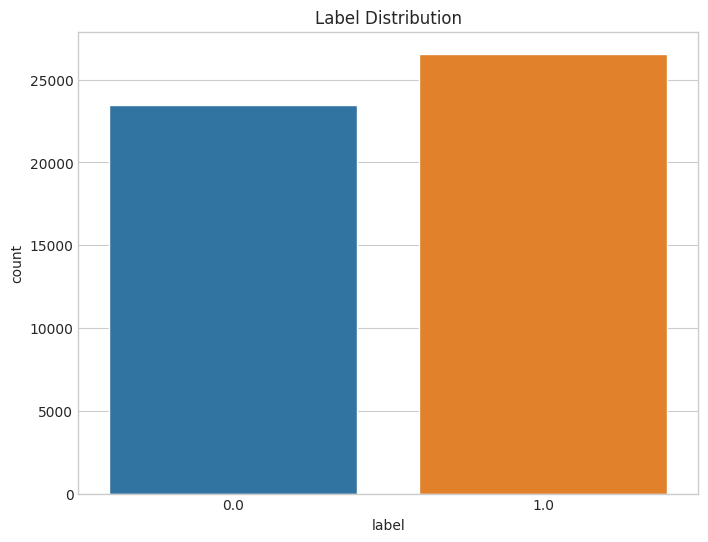

In [4]:
print("\n=== Label Distribution ===")
print(train_data['label'].value_counts())
print(train_data['label'].value_counts() / len(train_data))

# Label distribution visualization
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=train_data)
plt.title('Label Distribution')
plt.savefig('label_distribution.png')
plt.show()

<div style="background-color: #00397A; color: white; padding: 10px; text-align: center; font-size: 20px; font-weight: bold; border-radius: 10px; margin: 10px 0;">
Zero Value Analysis
</div>


=== Ratio of Zero Values ===
f20      0.65142
f16      0.56742
f12      0.49910
f8       0.49198
label    0.46870
f15      0.00000
f26      0.00000
f25      0.00000
f24      0.00000
f23      0.00000
f22      0.00000
f21      0.00000
f19      0.00000
f18      0.00000
f17      0.00000
f13      0.00000
f14      0.00000
f0       0.00000
f11      0.00000
f10      0.00000
f9       0.00000
f7       0.00000
f6       0.00000
f5       0.00000
f4       0.00000
f3       0.00000
f2       0.00000
f1       0.00000
f27      0.00000
dtype: float64

=== Features with High Zero Content ===
['f20', 'f16', 'f12', 'f8', 'label']

=== Distribution of Features with High Zero Content ===


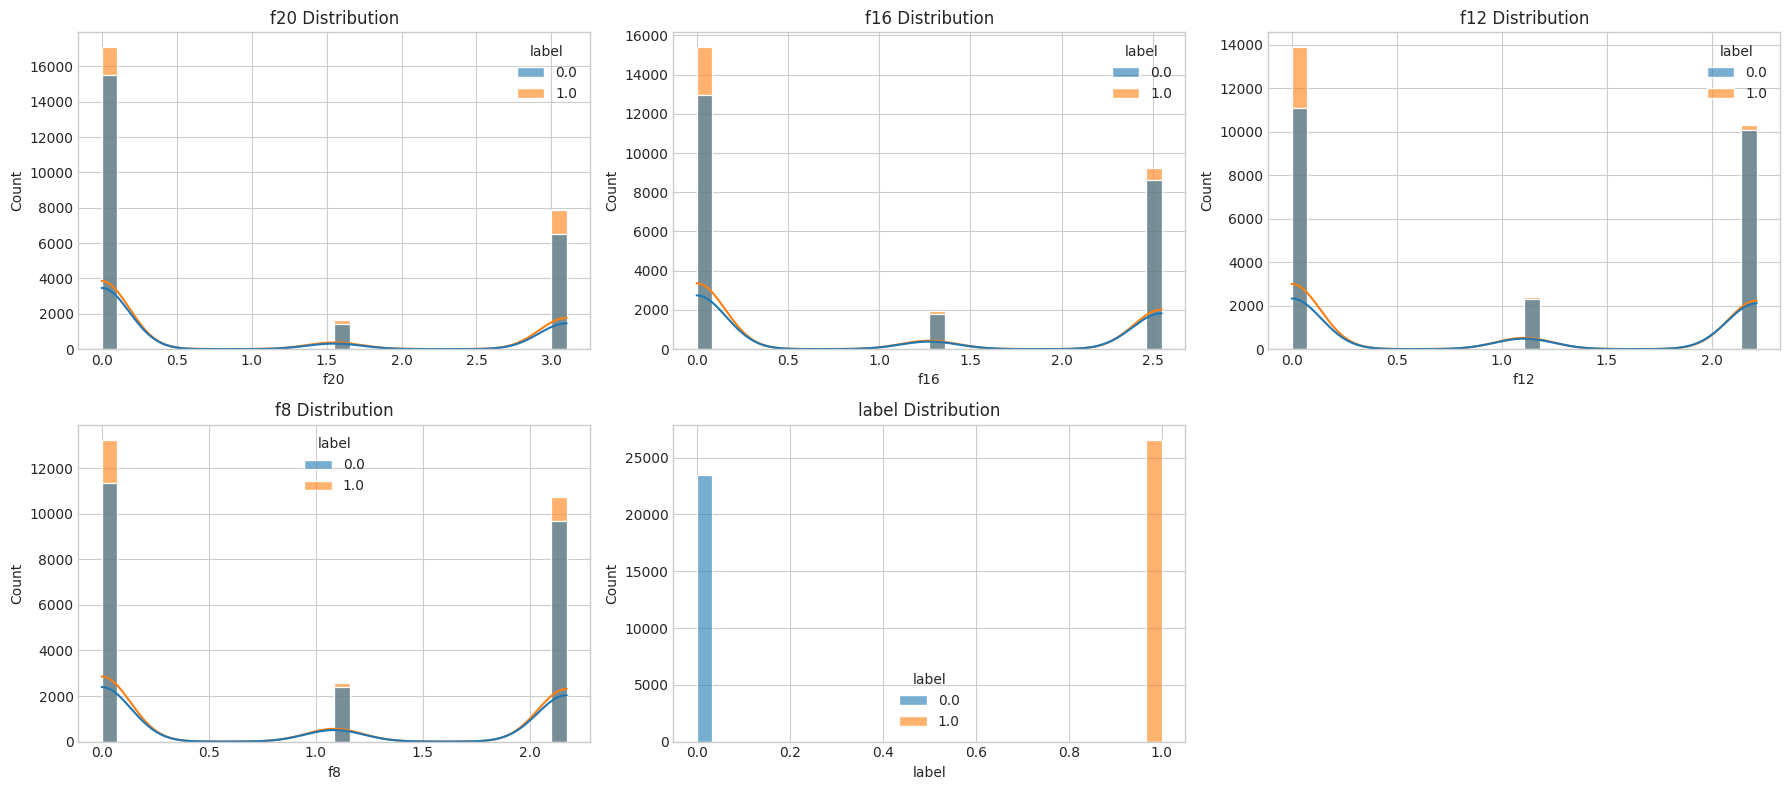

In [5]:
# Ratio of zero values
print("\n=== Ratio of Zero Values ===")
zero_ratios = check_zero_ratio(train_data)
print(zero_ratios)

# Features with high zero content
high_zero_features = zero_ratios[zero_ratios > 0.3].index.tolist()
print("\n=== Features with High Zero Content ===")
print(high_zero_features)

# Visualization of features with high zero content
if len(high_zero_features) > 0:
    print("\n=== Distribution of Features with High Zero Content ===")
    plot_feature_distributions(train_data, high_zero_features)

<div style="background-color: #00397A; color: white; padding: 10px; text-align: center; font-size: 20px; font-weight: bold; border-radius: 10px; margin: 10px 0;">
Correlation Analysis
</div>


=== Correlation Analysis ===


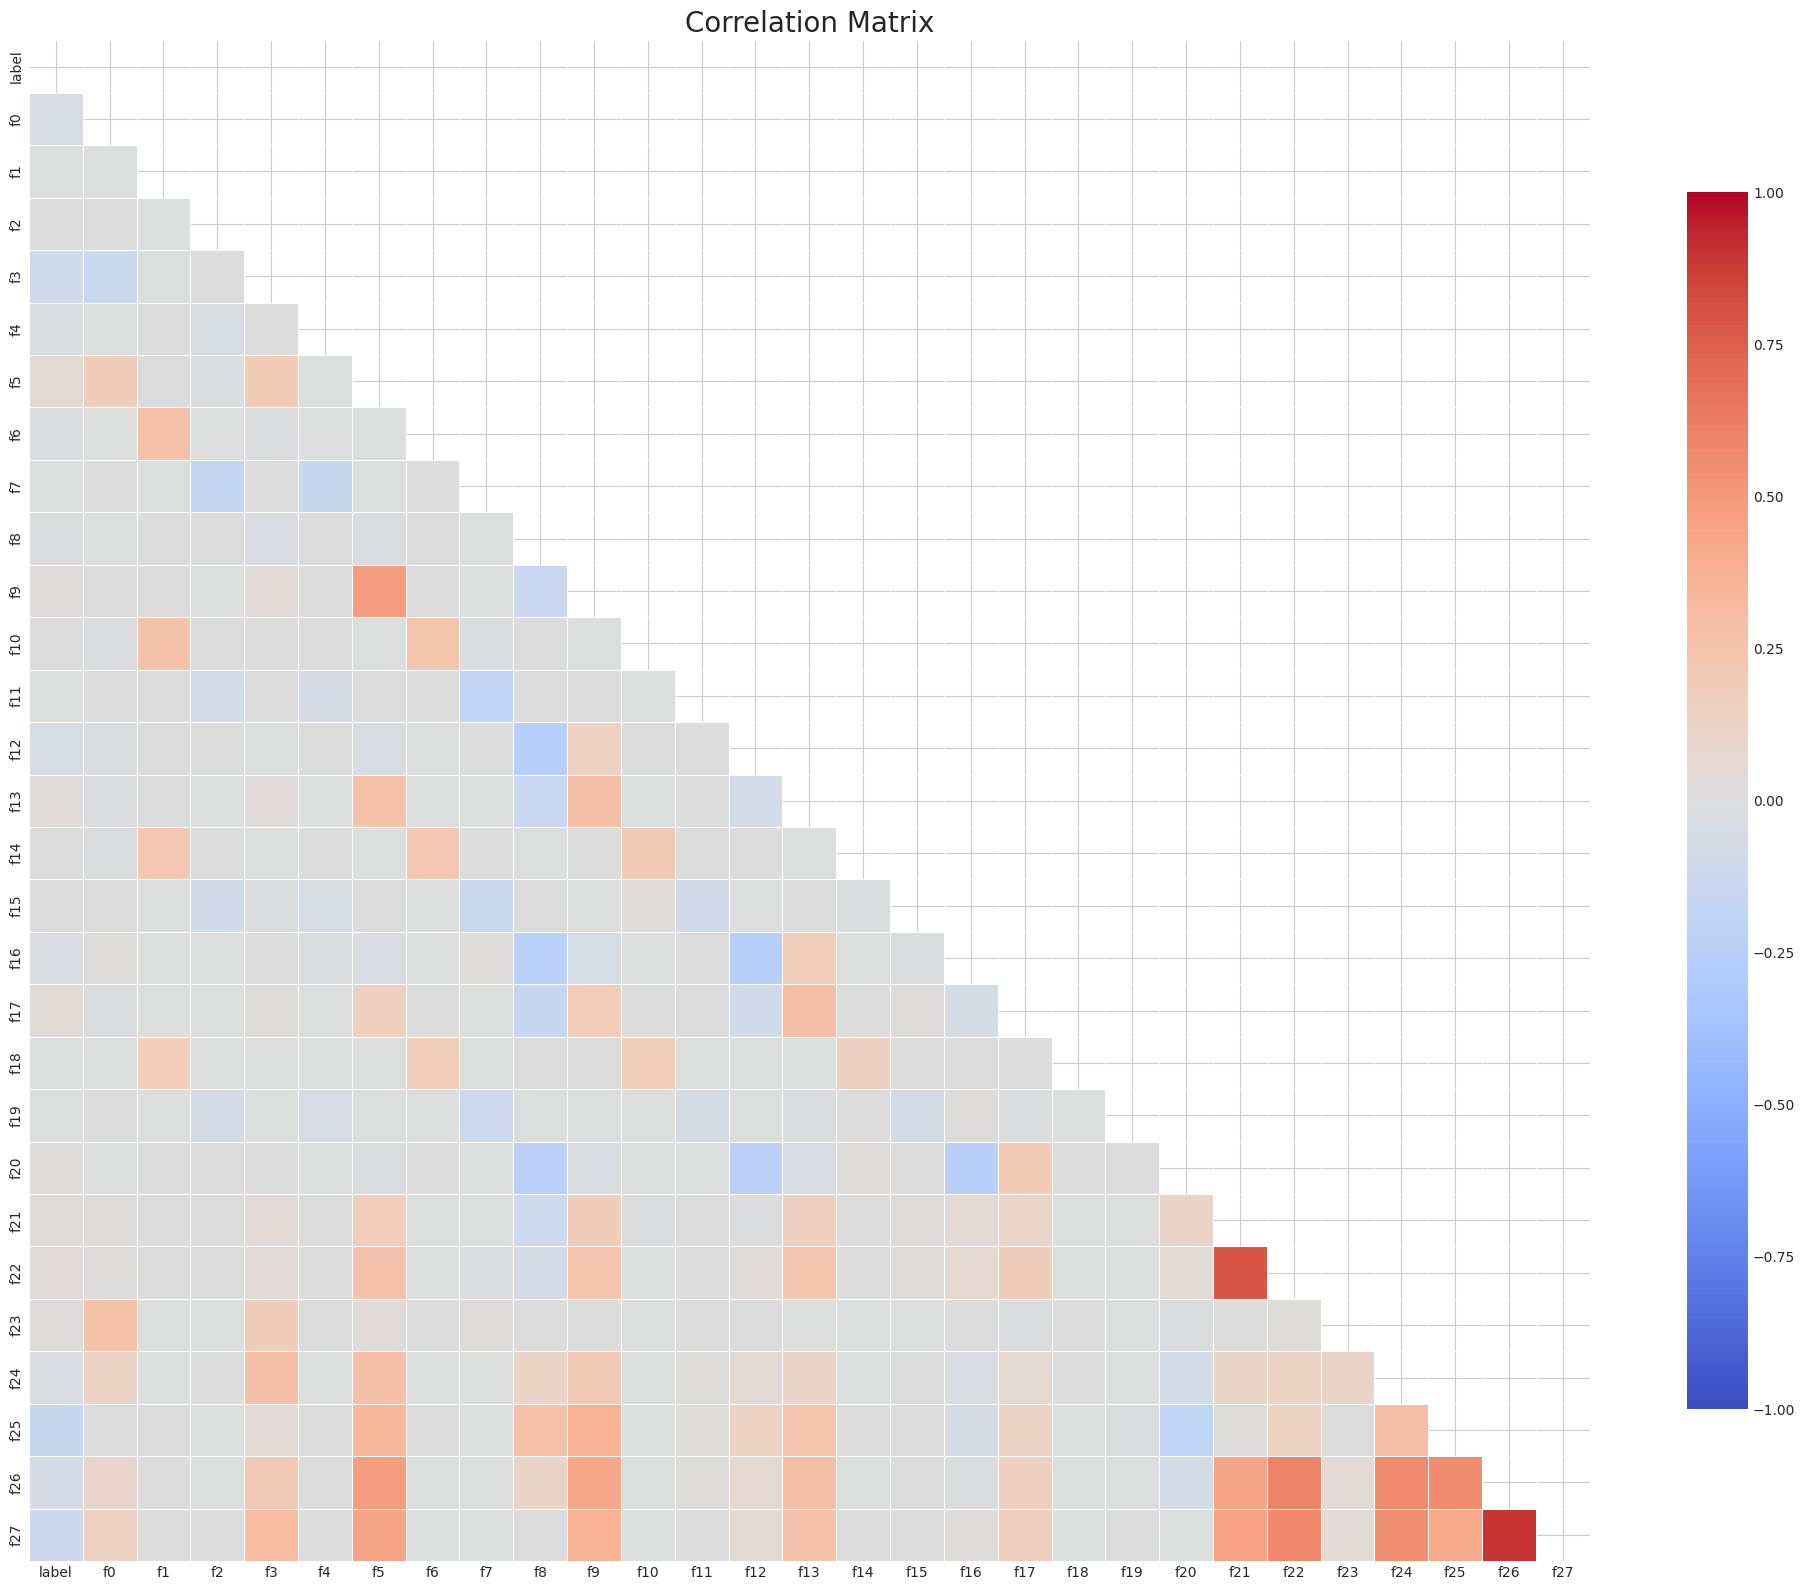

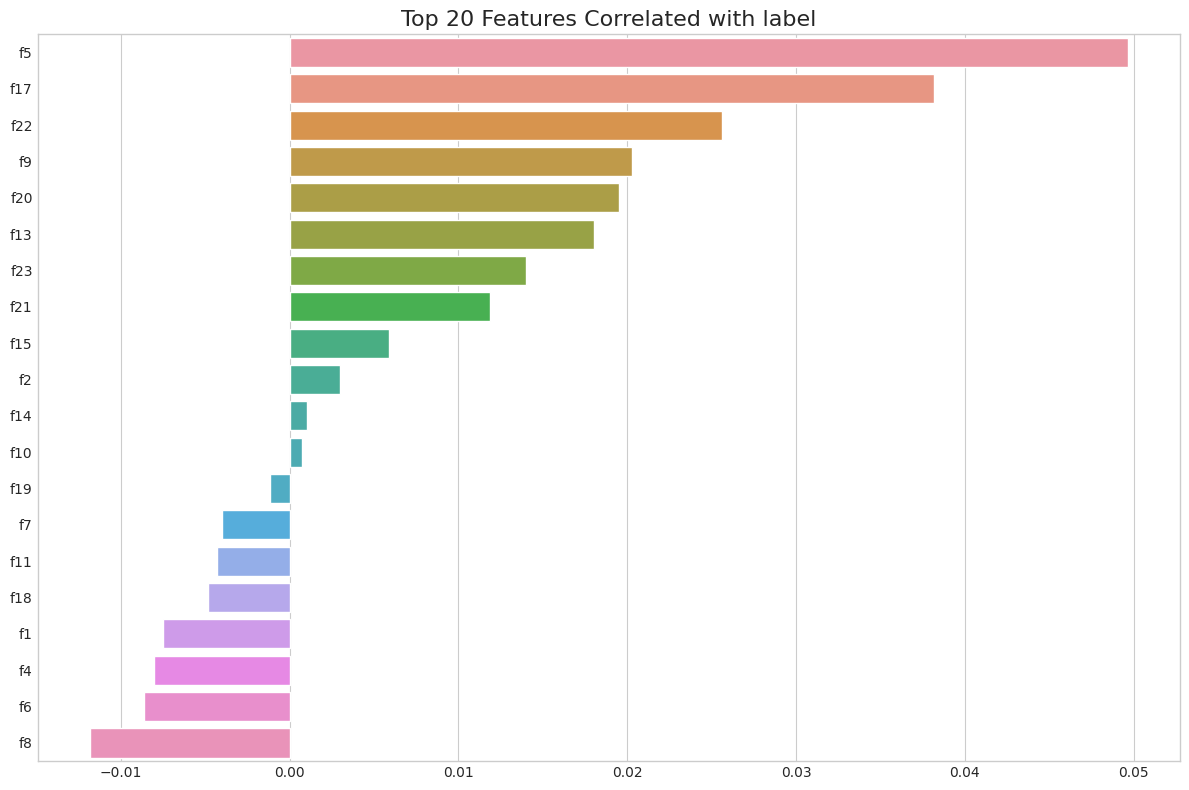

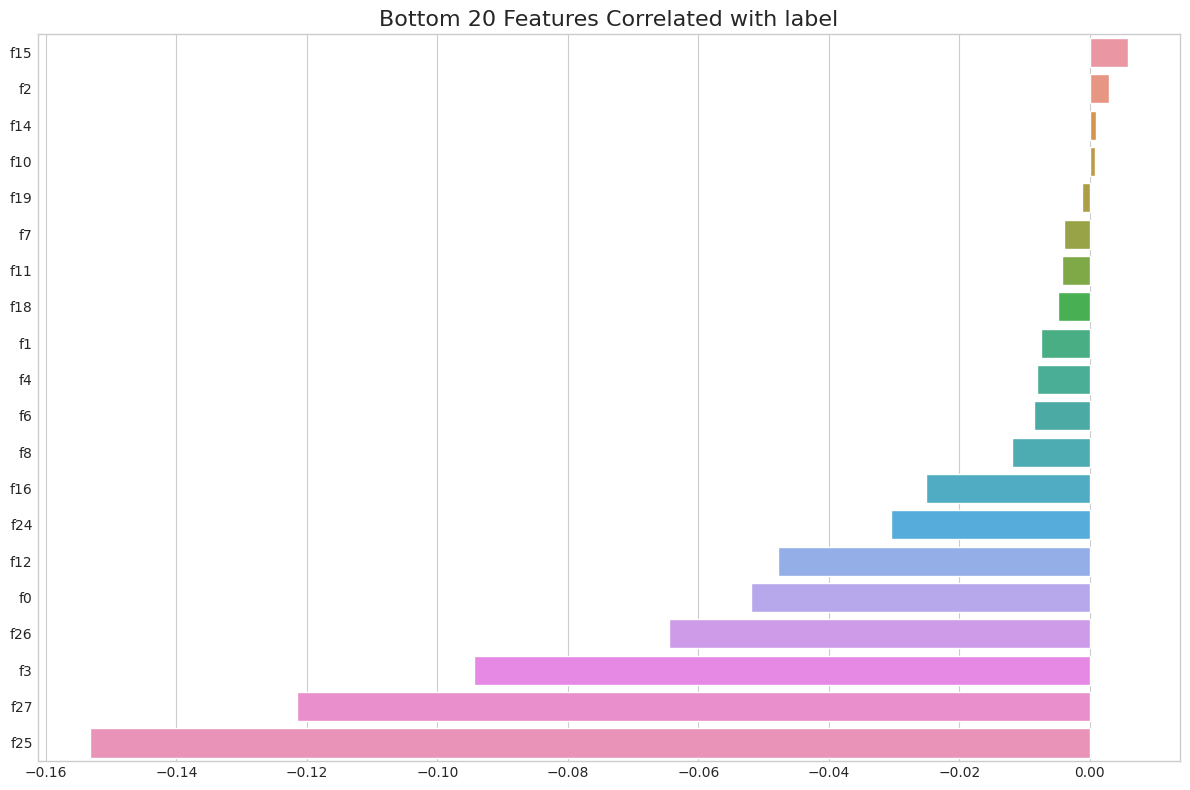


=== Detailed Examination of Top Correlated Features ===


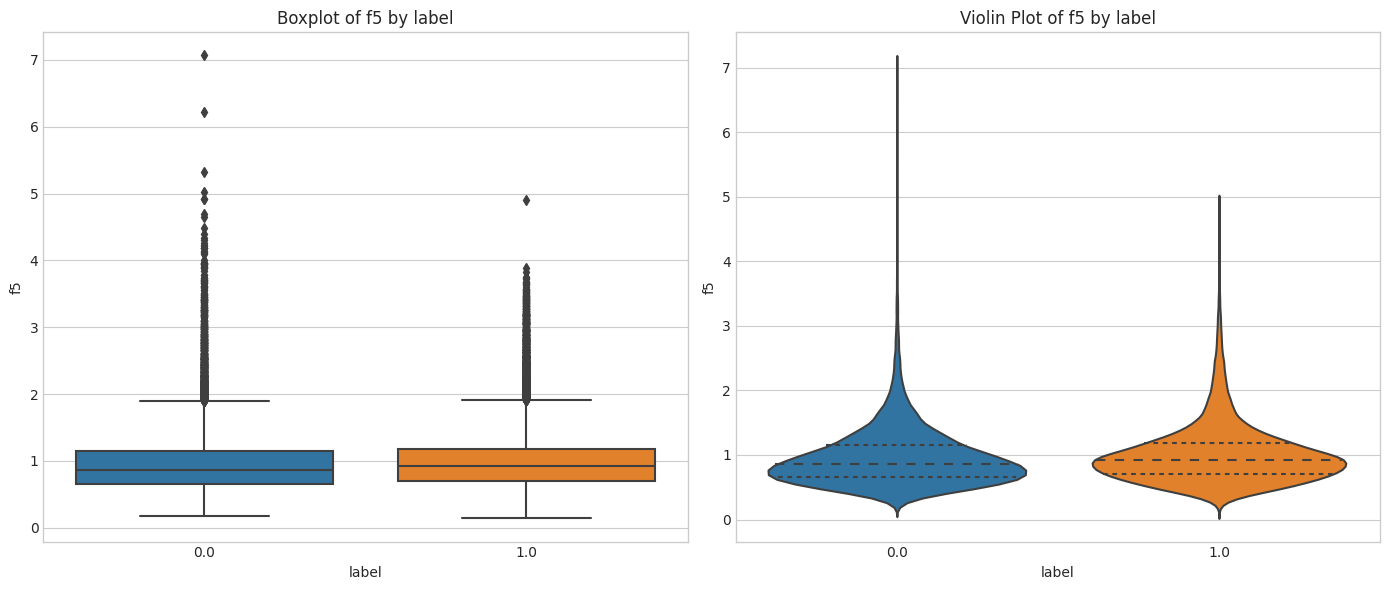

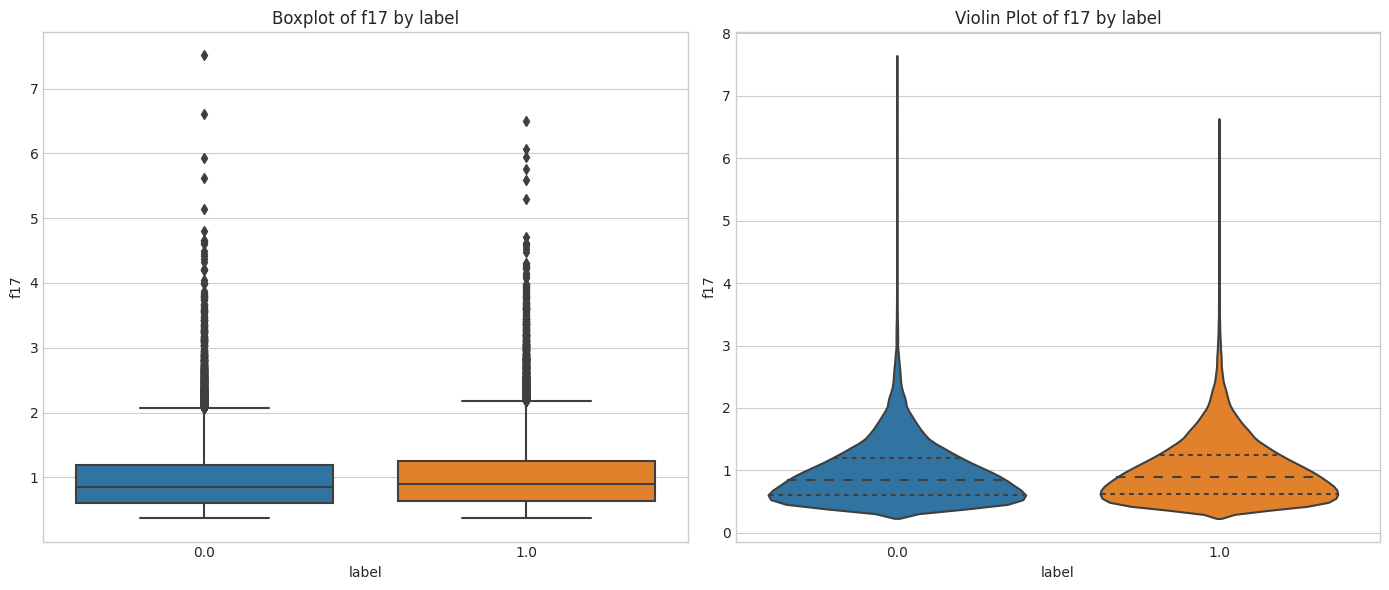

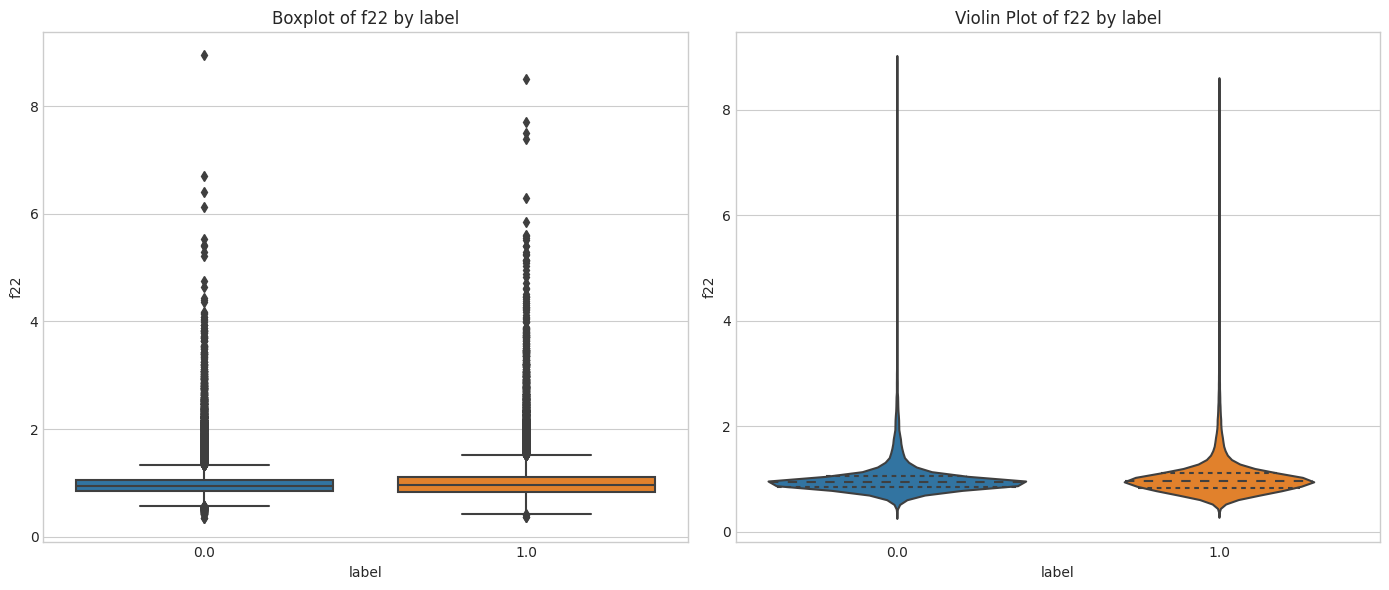

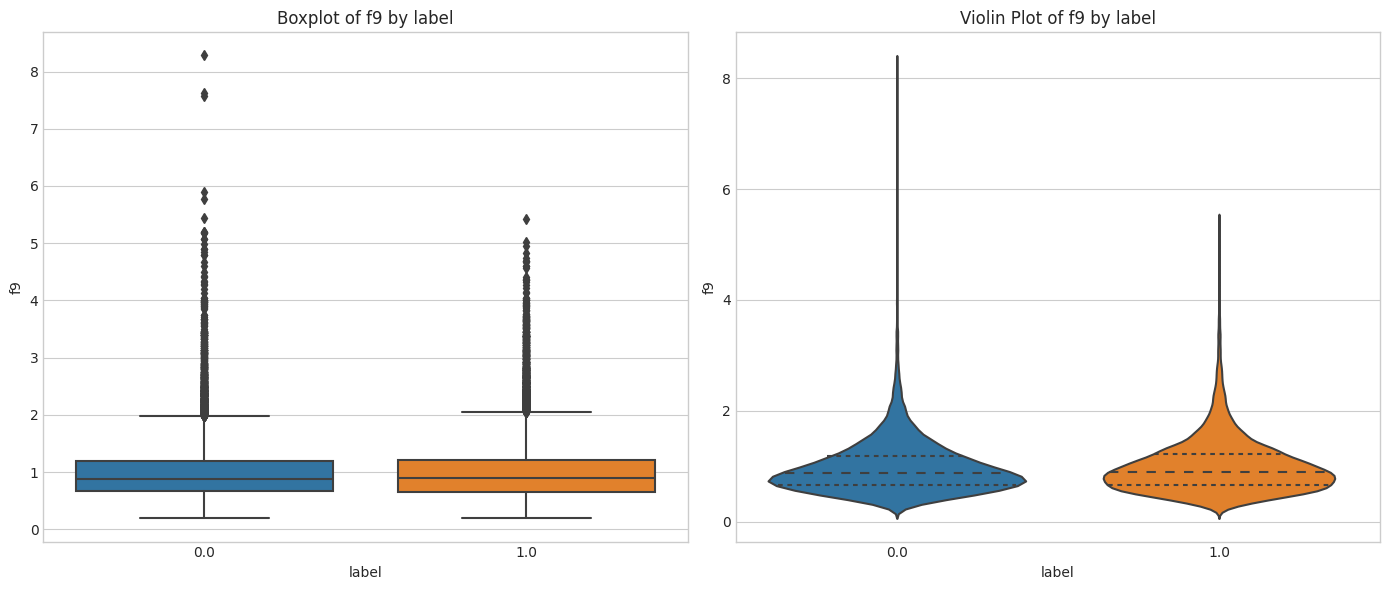

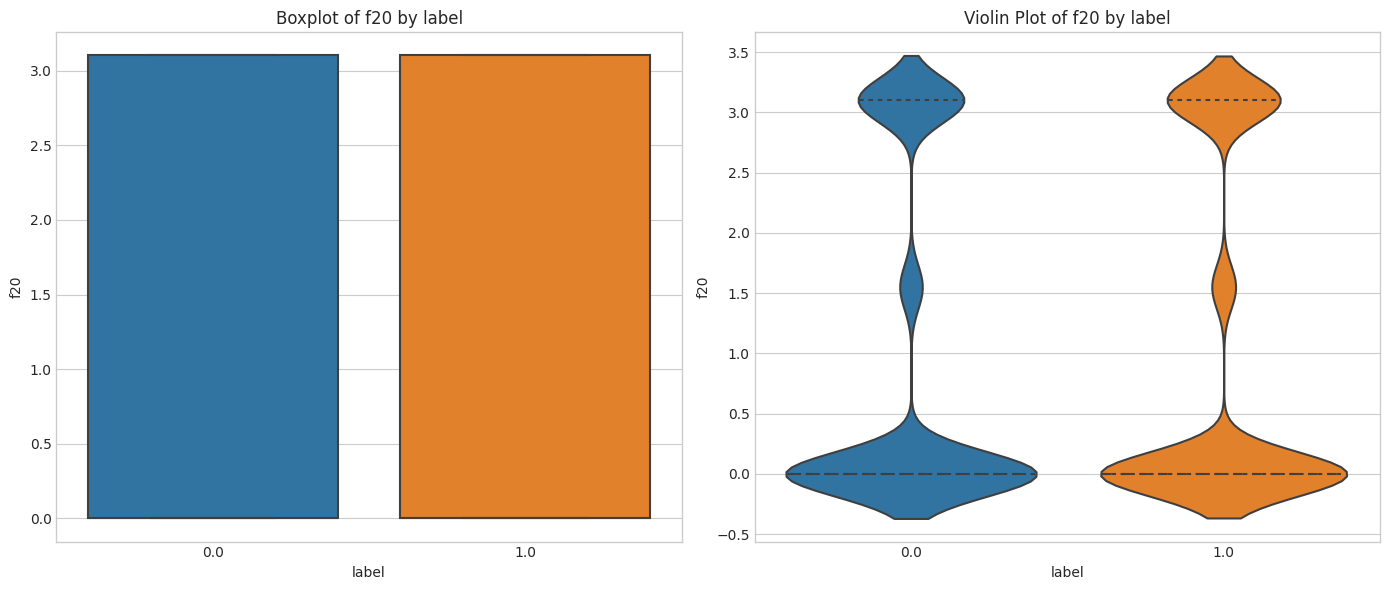

In [6]:
# Correlation analysis
print("\n=== Correlation Analysis ===")
correlations = plot_correlation_matrix(train_data, 'label')

# Detailed examination of top correlated features
top_corr_features = correlations.iloc[1:6].index.tolist()  # Top 5 features (excluding label)
print("\n=== Detailed Examination of Top Correlated Features ===")
for feature in top_corr_features:
    analyze_feature_by_target(train_data, feature, 'label')

<div style="background-color: #00397A; color: white; padding: 10px; text-align: center; font-size: 20px; font-weight: bold; border-radius: 10px; margin: 10px 0;">
Outlier Analysis
</div>

In [7]:
# Outlier analysis
print("\n=== Outlier Analysis ===")
for col in train_data.columns[1:]:  # All features except label
    has_outlier = check_outlier(train_data, col)
    print(f"{col}: {'Has outliers' if has_outlier else 'No outliers'}")


=== Outlier Analysis ===
f0: Has outliers
f1: No outliers
f2: No outliers
f3: No outliers
f4: No outliers
f5: Has outliers
f6: No outliers
f7: No outliers
f8: No outliers
f9: Has outliers
f10: No outliers
f11: No outliers
f12: No outliers
f13: Has outliers
f14: No outliers
f15: No outliers
f16: No outliers
f17: Has outliers
f18: No outliers
f19: No outliers
f20: No outliers
f21: Has outliers
f22: Has outliers
f23: Has outliers
f24: Has outliers
f25: Has outliers
f26: Has outliers
f27: Has outliers


<div style="background-color: #00397A; color: white; padding: 10px; text-align: center; font-size: 20px; font-weight: bold; border-radius: 10px; margin: 10px 0;">
Feature Distribution Analysis
</div>


=== Feature Distributions ===


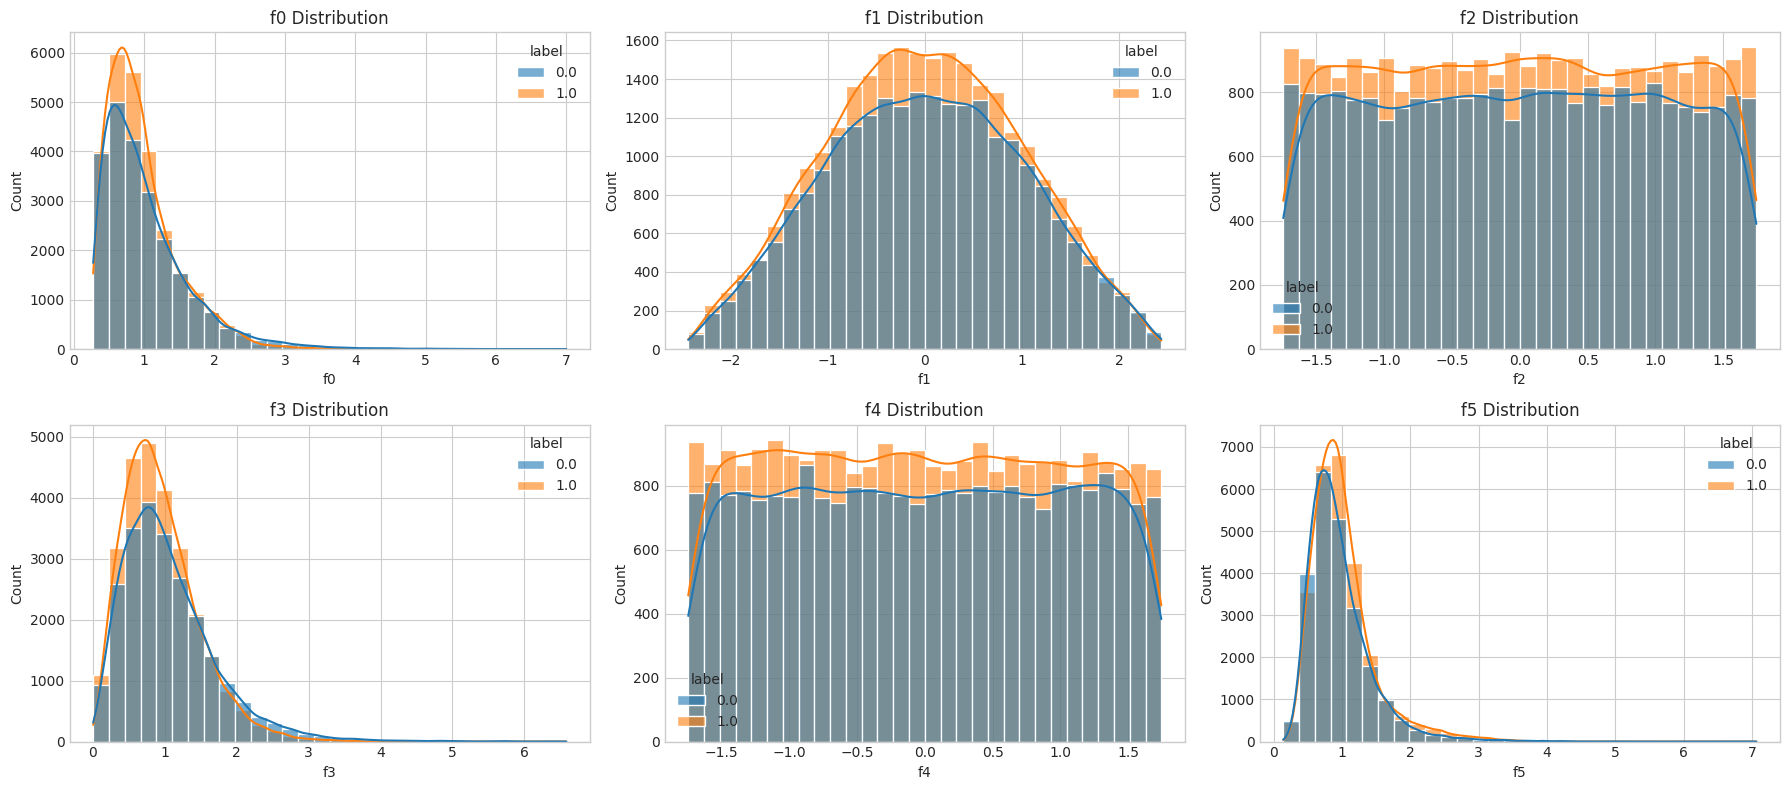

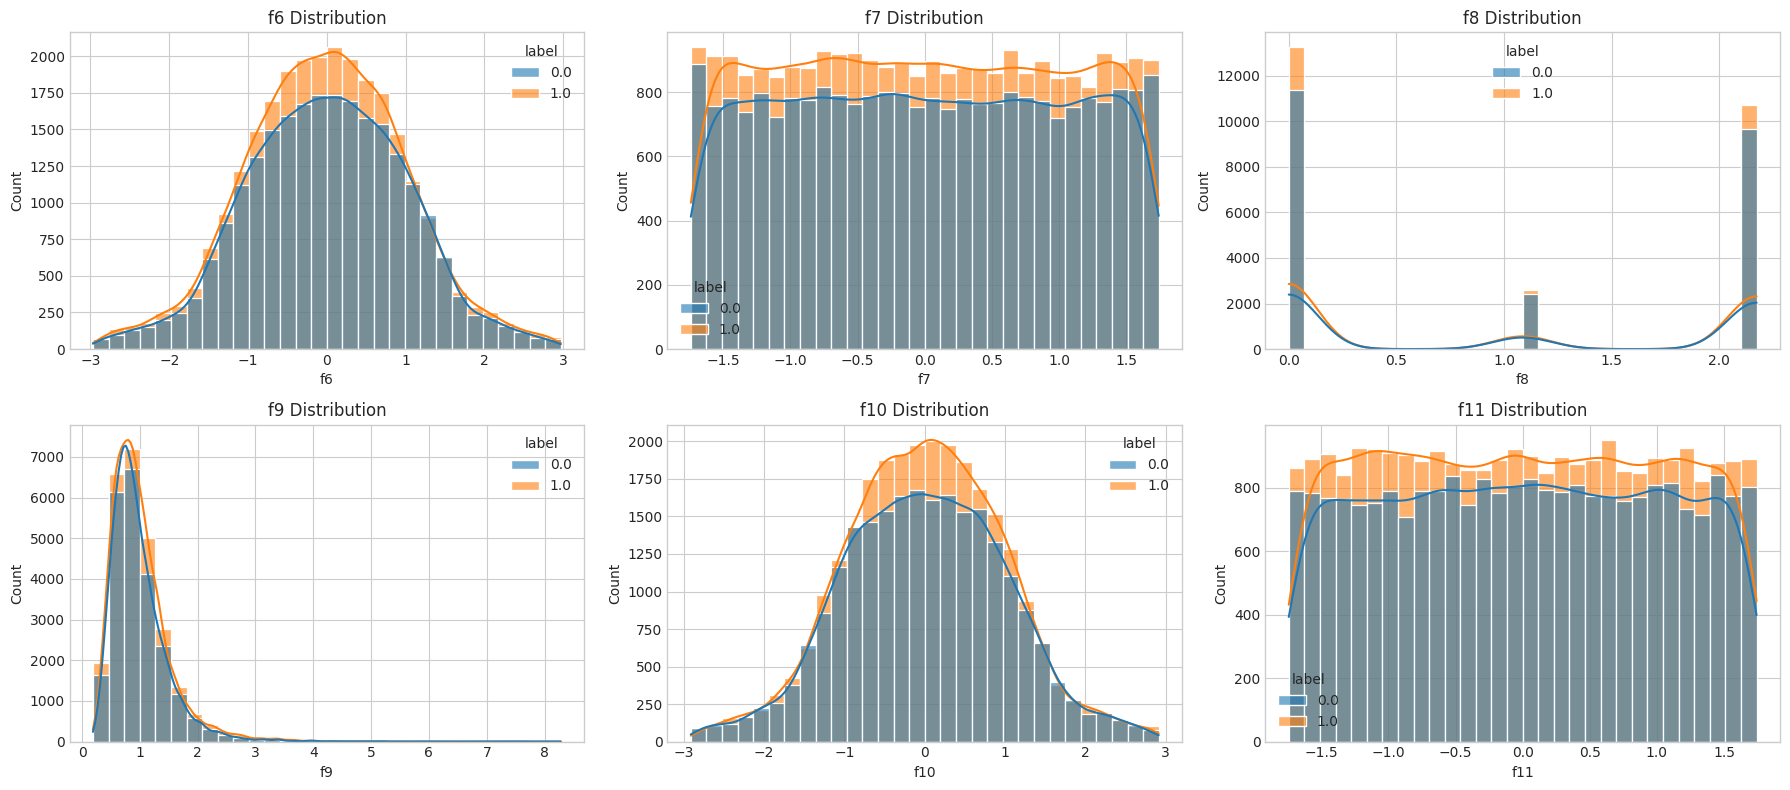

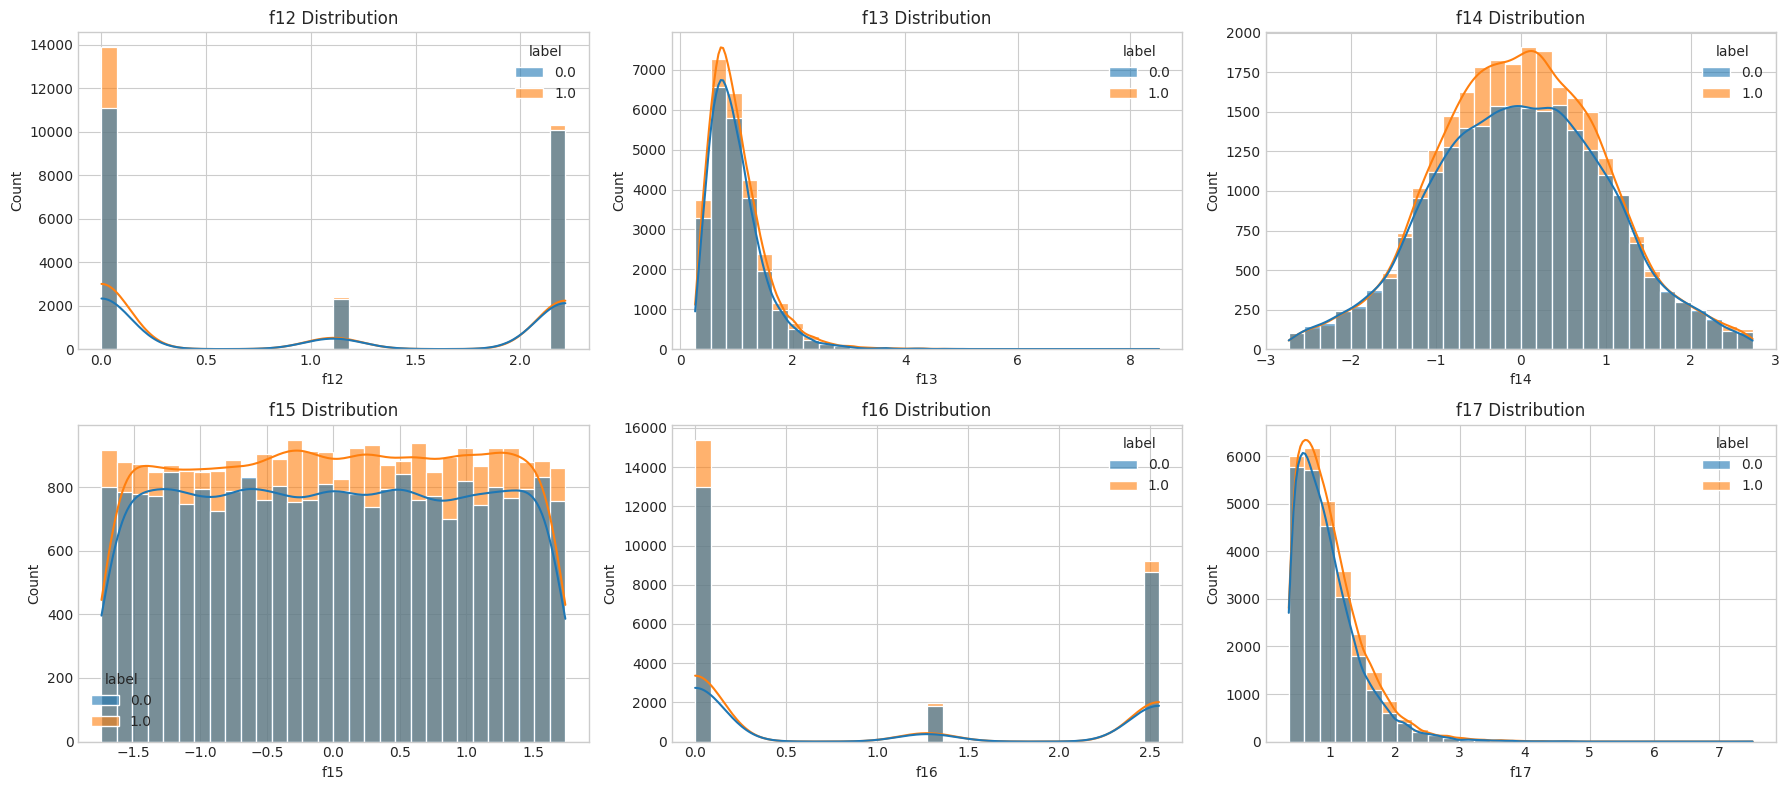

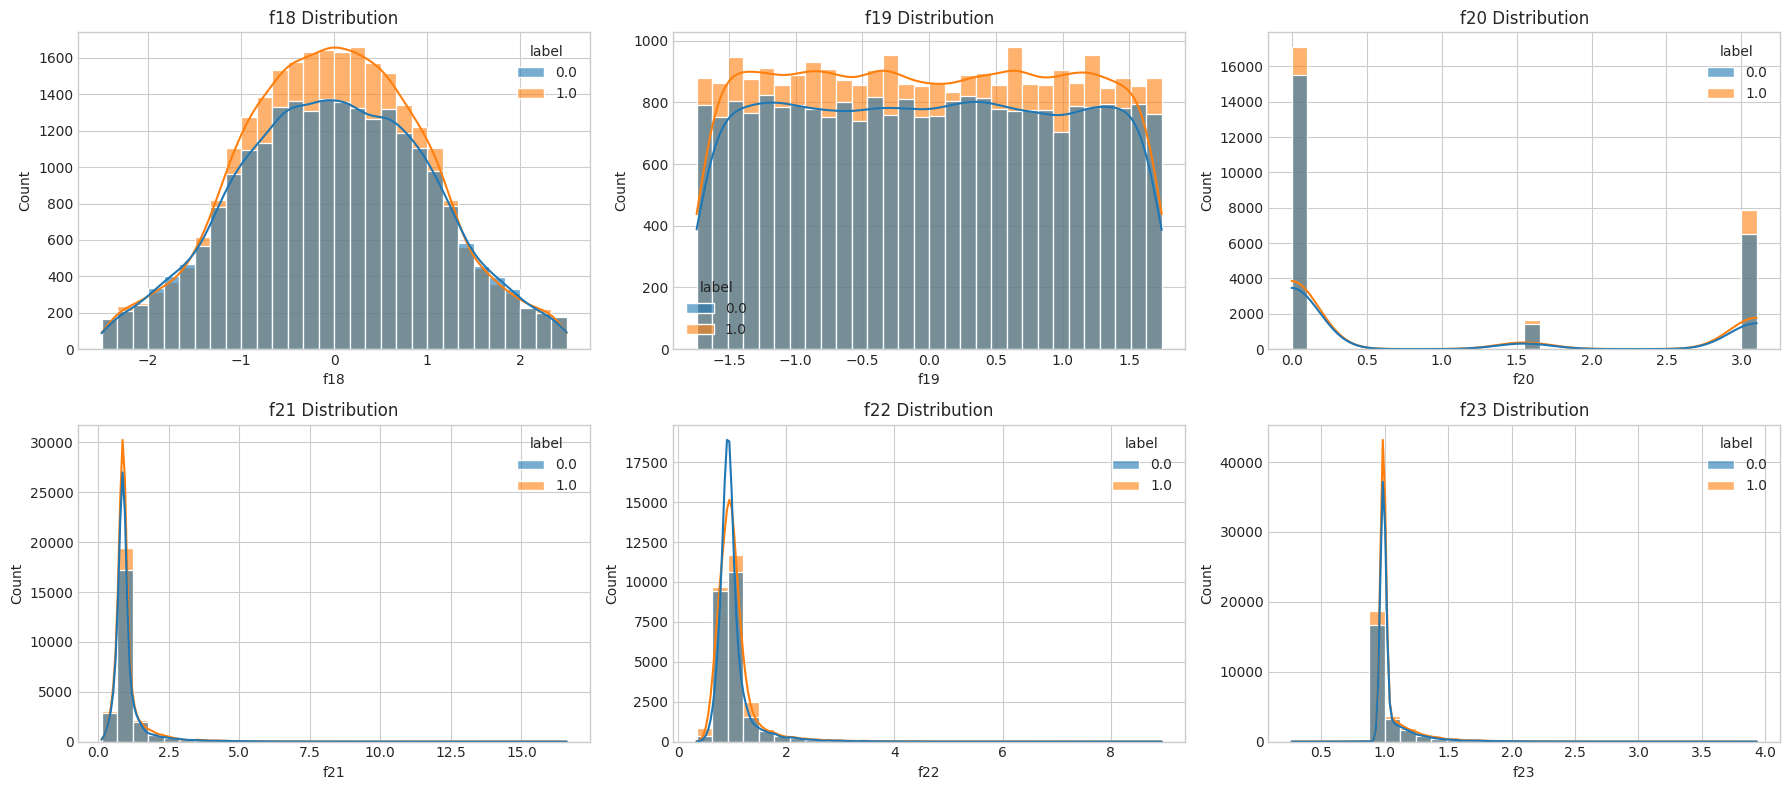

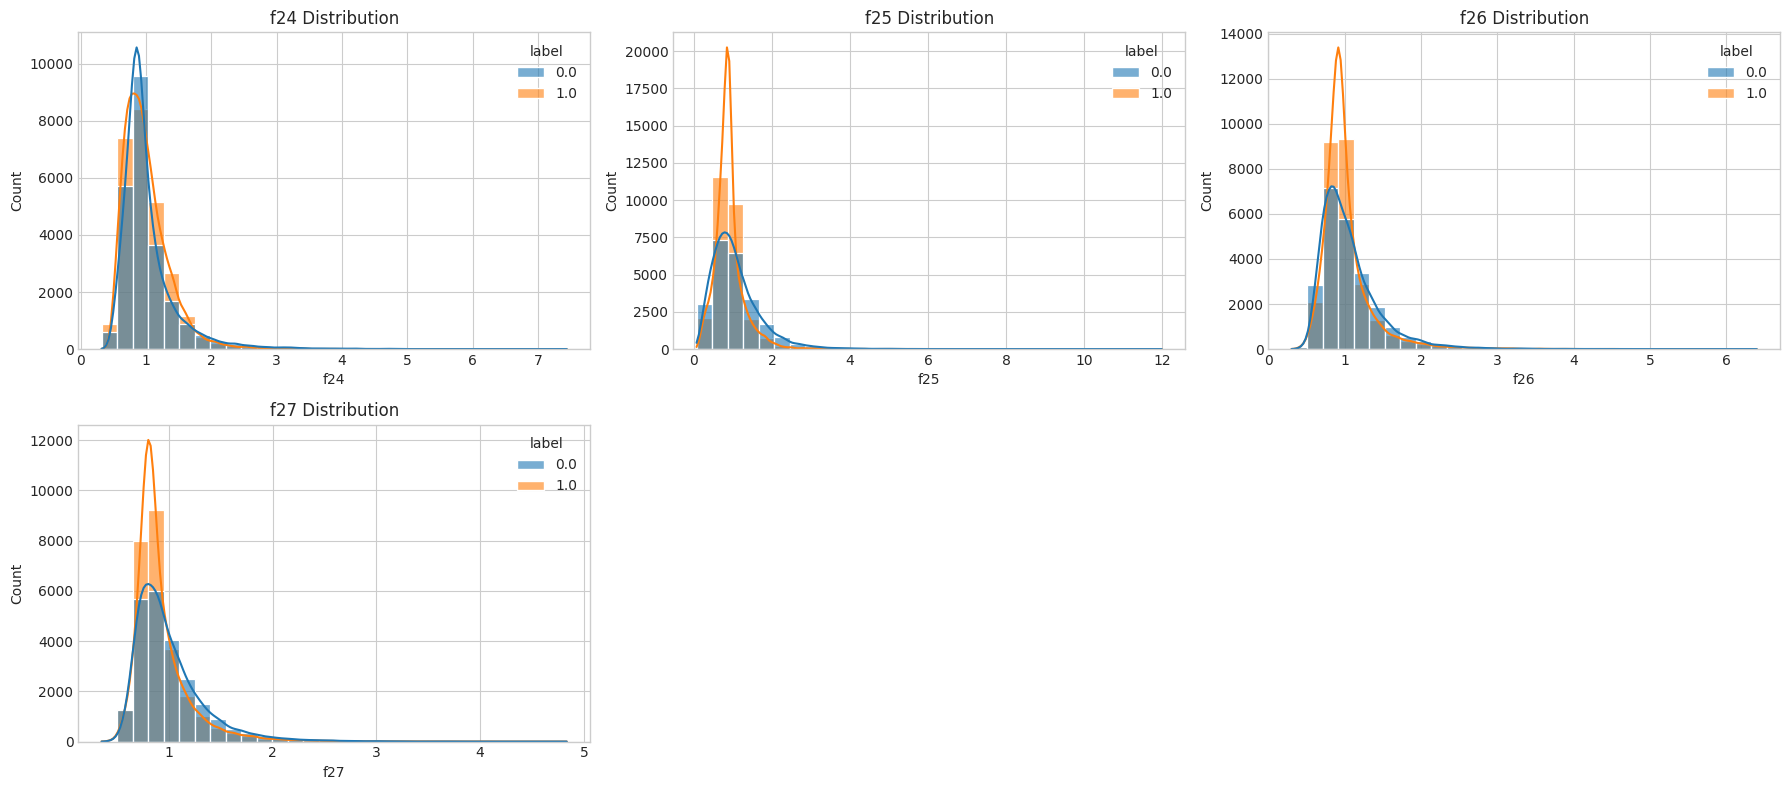

In [8]:
# Feature distributions - visualize all features in small groups
print("\n=== Feature Distributions ===")
all_features = train_data.columns[1:].tolist()  # All features except label
for i in range(0, len(all_features), 6):  # Show 6 features at a time
    feature_group = all_features[i:i + 6]
    plot_feature_distributions(train_data, feature_group)

<div style="background-color: #00397A; color: white; padding: 10px; text-align: center; font-size: 20px; font-weight: bold; border-radius: 10px; margin: 10px 0;">
Feature Importance Analysis
</div>


=== Random Forest Feature Importance ===


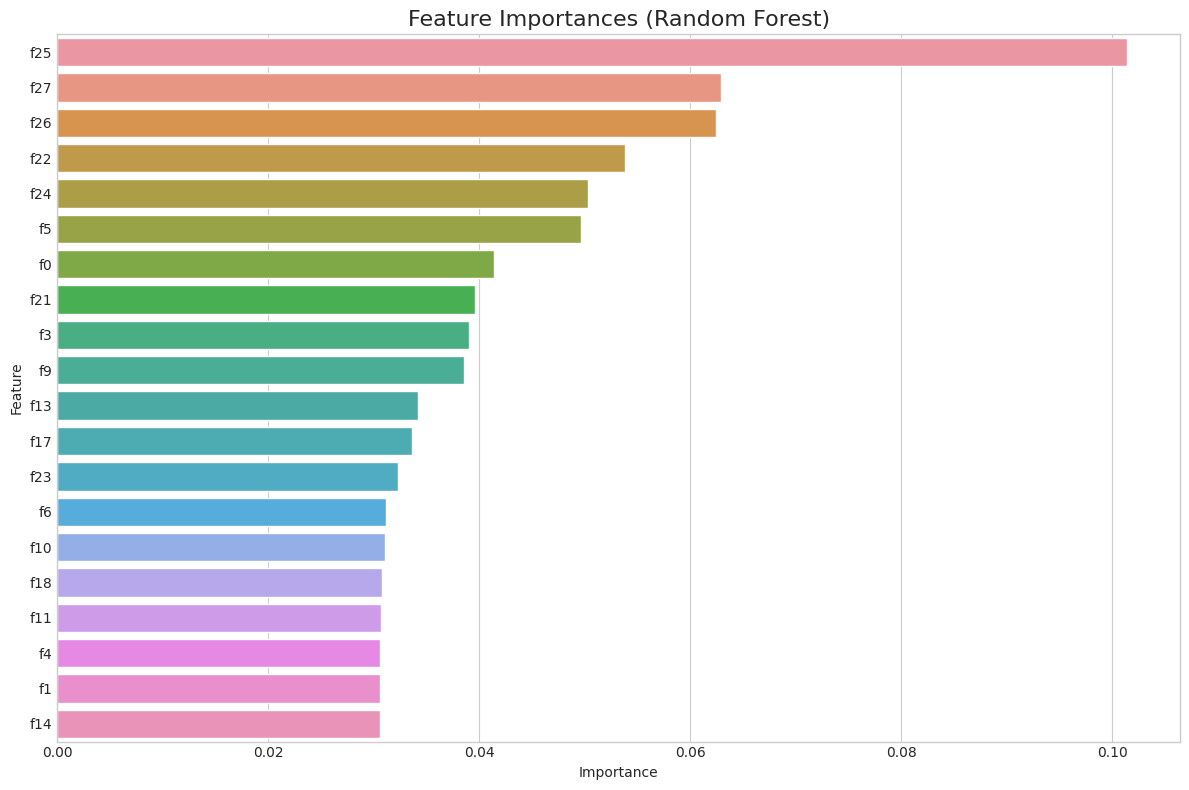

In [9]:
# Random Forest feature importance
print("\n=== Random Forest Feature Importance ===")
feature_imp = plot_feature_importances_for_rf(train_data, 'label')

<div style="background-color: #00397A; color: white; padding: 10px; text-align: center; font-size: 20px; font-weight: bold; border-radius: 10px; margin: 10px 0;">
Pairplot Analysis of Top Features
</div>


=== Pairplot Analysis of Top Features ===


<Figure size 1500x1500 with 0 Axes>

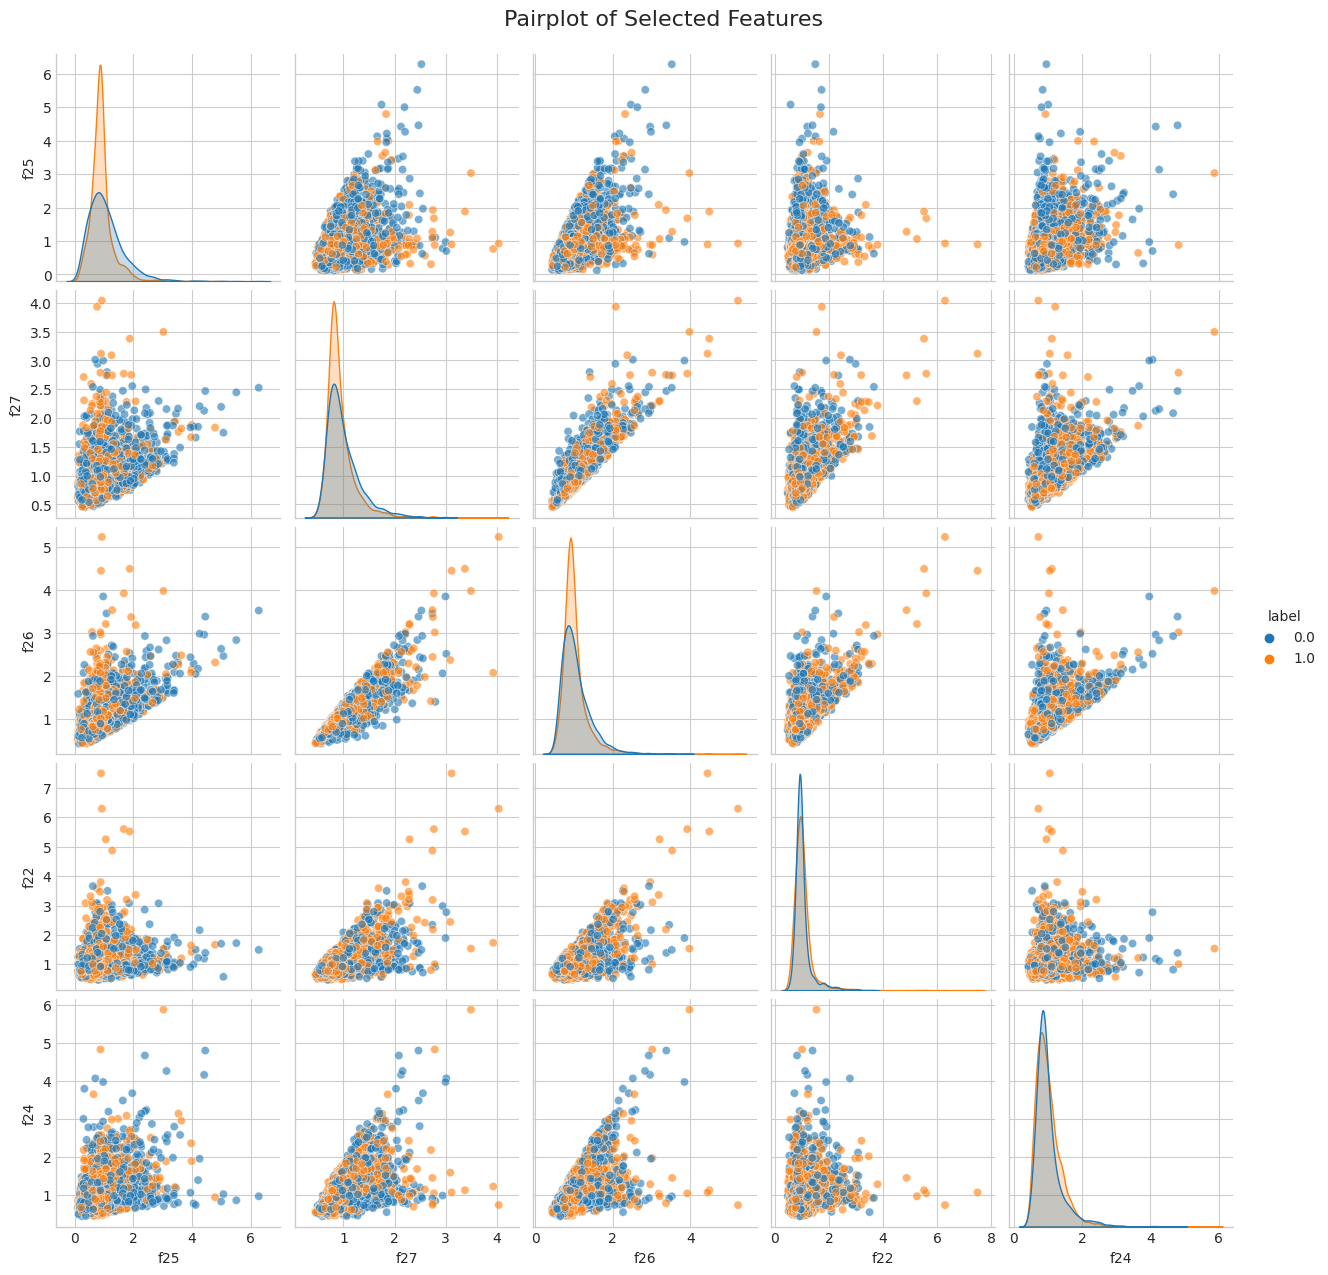

In [10]:
# Pairplot - visualize most important features
top_features = feature_imp['Feature'].head(5).tolist()
print("\n=== Pairplot Analysis of Top Features ===")
plot_pairplot(train_data, top_features, 'label')

<div style="background-color: #00397A; color: white; padding: 10px; text-align: center; font-size: 20px; font-weight: bold; border-radius: 10px; margin: 10px 0;">
Summary and Conclusions
</div>

In [11]:
# Summary information
print("\n=== EDA Summary ===")
print(f"Total number of records: {len(train_data)}")
print(f"Number of features: {train_data.shape[1] - 1}")  # Excluding label
print(f"Positive class ratio: {train_data['label'].mean():.4f}")
print(f"Number of features with high zero content: {len(high_zero_features)}")
print(f"Number of features with outliers: {sum([check_outlier(train_data, col) for col in train_data.columns[1:]])}")


=== EDA Summary ===
Total number of records: 50000
Number of features: 28
Positive class ratio: 0.5313
Number of features with high zero content: 5
Number of features with outliers: 12


## 📈 Key Insights from EDA

After conducting a comprehensive exploratory data analysis of the Higgs Boson dataset, we've discovered several important insights:

1. **Class Distribution**: Understanding the balance between signal (Higgs boson) and background events

2. **Correlation Patterns**: Identified key features that show strong correlation with the target variable

3. **Feature Importance**: Determined the most influential features for classification using Random Forest

4. **Data Quality**: Analyzed outliers and zero-value distributions across features

5. **Feature Relationships**: Examined interactions between top features through pairplot visualization

These insights will guide our feature engineering and modeling approaches in the next notebook, where we'll develop machine learning models to effectively classify Higgs boson particles.

## Acknowledgments

This work would not have been possible without the valuable guidance and support of
[Ali Can Payaslı](https://www.kaggle.com/alicanpayasli), Kaggle Master.

His expertise and insights were instrumental in the development of this analysis.